It turns out the monthly stipends will have to be huge to actually get everyone out of rent burden. Even in Riverside it's like 16k based on the current rent. So, if we set the yearly increases to be whatever it takes to stay out of rent burden, they will be very large. In this example, the change in stipend is just set equal to the drawn % change in local rent, and then min/max constraints are applied.

Lots of potential ways to calculate initial housing stipend distribution, not sure what makes most sense yet. 

## Run Simulation

In [1]:
import numpy as np
import pandas as pd
from main import WageModel
from matplotlib import pyplot as plt
import os, sys
import csv
# Params/consts
# beta_rng and alpha_rng must be either numbers, lists of two, or nested lists of two
ucnames = ['UCM', 'UCR', 'UCD', 'UCLA', 'UCSD', 'UCB', 'UCI', 'UCSB', 'UCSC', 'UCSF']
i_max = 5
step_inc = 0.075
k_max = 10
r = 0.3
reps = 1000
tstep = 1
tfinal = 5

a = np.arange(1, 1+step_inc*i_max, step_inc)
bw = np.repeat(54e3,k_max)

alp_rng = 0.03
stepwide_alp = False

# # Set stipend so salary/rent = r
# rents = pd.read_csv('rentdata.csv').drop('Year', axis=1)
# rent_cur = rents.iloc[-1:].values.tolist()[0]
# h = []
# for k,R in enumerate(rent_cur):
#     h_k = R*12/r - bw[k]
#     if h_k > 0:
#         h.append(h_k)
#     else:
#         h.append(0)
# Linear stipend increase, arbitrary slope
h_inc = 300
h = np.arange(100, h_inc*10, h_inc)
# # Linear fit on cost of living vs campus to get housing stipend
# col = np.array([34216., 38812.8, 40934.4, 45531.2, 47299.2, 50460.8, 51833.6, 52665.6, 57075.2, 64084.8])
# x = np.arange(len(col))
# m, b = np.polyfit(x, col, 1)
# m_frac = 0.25 # fraction of col slope to scale stipends by
# h = np.arange(0,m*m_frac*11,m*m_frac)

beta_rng = [[0.01,0.02],[0.01,0.02],[0.01,0.03],[0.01,0.06],[0.01,0.07],
            [0.01,0.07],[0.01,0.07],[0.01,0.08],[0.01,0.1],[0.01,0.12]]

y_max = 8
yf = np.array([2,4,5,6,y_max])
d = -0.06
y_grad = 3
S_tot = 1

# Create csv for writing
outfn = 'out.csv'
params = ['rep','t','k']
for i in range(len(a)):
    params.append('w_'+str(i))
params.append('h')
overwrite = True ### CAREFUL!
if os.path.isfile(outfn) == True:
    if overwrite:
        os.remove(outfn)
    else:
        sys.exit('Set overwrite to True to overwrite existing output file')

with open(outfn, 'w') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(params)
    for rep in range(reps):
        bw = np.repeat(54e3,k_max)
        h_inc = 300
        h = np.arange(100, h_inc*10, h_inc)
        model = WageModel(a, bw, alp_rng, stepwide_alp, h, beta_rng, r,
                          yf, y_max, d, y_grad, S_tot, rep)
        model.runsim(outfile=outfile, verbose=False)

## Analysis

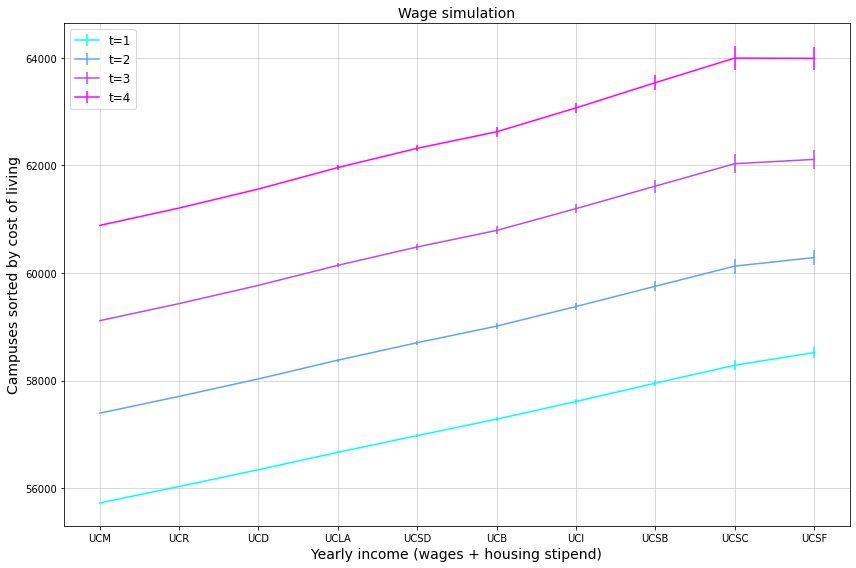

In [2]:
from matplotlib import cm

df = pd.read_csv('out.csv')

fig = plt.figure(figsize=(12,8))
colmap = cm.get_cmap('cool', 12)
for i, t in enumerate(np.arange(0+tstep, tfinal, tstep)):
# for t in [0]:
    income_avgs = []
    income_stds = []
    for k in range(len(bw)):
        df_sub = df[(df.t == t) & (df.k == k)]
        bw_avg, bw_std = np.mean(df_sub['w_0']), np.std(df_sub['w_0'])
        h_avg, h_std = np.mean(df_sub['h']), np.std(df_sub['h'])
        income_avg = bw_avg + h_avg
        income_avgs.append(income_avg)
        income_std = np.sqrt(bw_std**2 + h_std**2)
        income_stds.append(income_std)
    plt.errorbar(ucnames,income_avgs,yerr=income_stds, 
                 label='t={}'.format(str(t)), c=colmap(i/3))
plt.grid(True,alpha=0.6)
plt.title('Wage simulation', fontsize=14)
plt.xlabel('Yearly income (wages + housing stipend)', fontsize=14)
plt.ylabel('Campuses sorted by cost of living', fontsize=14)
plt.tight_layout()
plt.legend(fontsize='large')
plt.show()

### Misc

It actually takes a huge stipend to get out of rent burden, even for Riverside

In [13]:
S = 1751*12/0.3 # non rent burden salary for r=0.3 and 2023 Riverside rent
S

70040.0

In [8]:
S = 3293*12/0.3 # non rent burden salary for r=0.3 and 2023 SC rent
S

131720.0

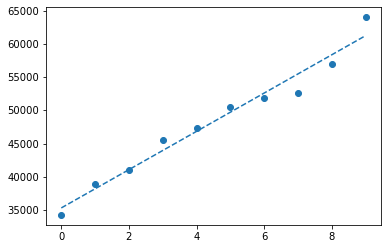

In [23]:
# Linear fit on cost of living vs campus
col = np.array([34216., 38812.8, 40934.4, 45531.2, 47299.2, 50460.8, 51833.6, 52665.6, 57075.2, 64084.8])
x = np.arange(len(col))
m, b = np.polyfit(x, col, 1)
plt.scatter(x, col)
plt.plot(x, m*x+b, ls='--')